False news The classifier dataset consists of two independent features and one independent feature. The new task is to identify the information based on the title and text. 

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot


In [34]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
fake_data = pd.read_csv("train.csv",index_col=0)
fake_data.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [36]:
fake_data.shape

(20800, 4)

In [37]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   text    20761 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 812.5+ KB


Missing values are there in text and title, though its a minimum number we can use dropna to drop all nan values 


title      558
author    1957
text        39
label        0
dtype: int64


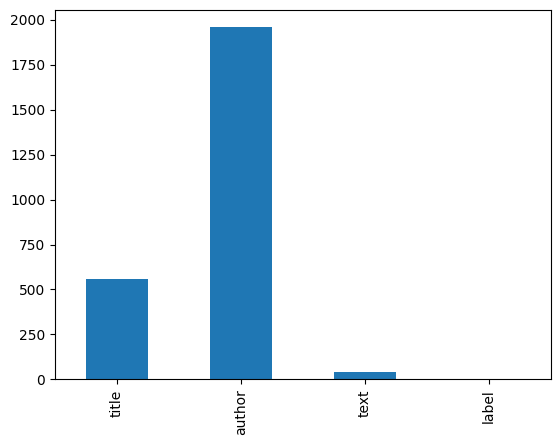

In [38]:
print(fake_data.isnull().sum())
fake_data.isnull().sum().plot(kind="bar")
plt.show()

To filling nan values in the data we simply using empty space

In [39]:
fake_data.groupby('label').count()

,title,author,text
label,,,
0,10387,10361,10387
1,9855,8482,10374


In [40]:
fake_data = fake_data.fillna('')

In [41]:
fake_data.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

 check dataset have equal amount of fake and real labels

In [42]:
fake_data.label.nunique()

2

In [43]:
fake_data['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

Almost real and fake data is equal,'1'represents real news and '0' represents fake news

<AxesSubplot:>

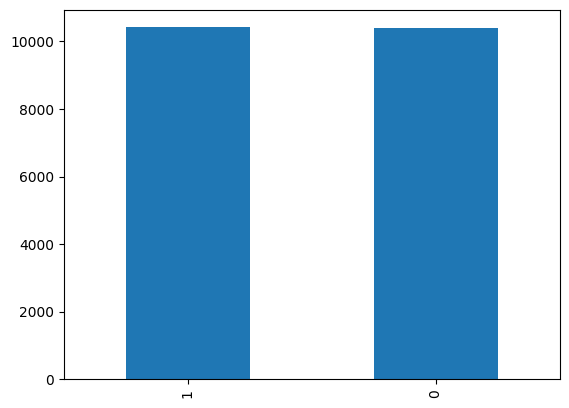

In [44]:
(fake_data['label'].value_counts()).plot(kind = 'bar')

Text preprocessing


In [45]:
from nltk.stem.porter import PorterStemmer

preprocessing the data before applying the onehot 

In [46]:
X = fake_data.drop(columns = ['label'])
X.reset_index(inplace = True)


In [47]:
y = fake_data['label']


In [48]:
m = X.copy()
m.reset_index(inplace=True)

In [49]:
ps = PorterStemmer()
corpus = []
for i in range(0,len(m)):
    data = re.sub('[^a-zA-Z]',' ',m['title'][i])
    data = data.lower()
    data = data.split()
    data = [ps.stem(word) for word in data if not word in stopwords.words('english')]
    data = ''.join(data)
    corpus.append(data)
corpus_text = [' '.join(words) for words in corpus]

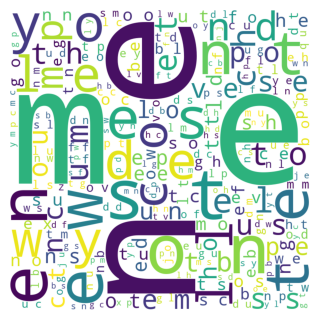

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine your text data into a single string
text_data = " ".join(corpus_text)  # corpus_text is the list of processed text

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(3,3), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()


In [50]:
voc_size = 5000
one_hotrep = [one_hot(word,voc_size) for word in corpus_text]

In [53]:
sent_len = 20
embedded_docs = pad_sequences(one_hotrep, padding = 'pre',maxlen = sent_len)

In [54]:
embedded_docs[0]

array([1048, 2113, 1558, 4277, 4133, 3847, 4466, 1942, 4960, 4277, 2694,
       2694, 1048,  891, 1916,  891,  360, 1048, 1048,  891])

In [55]:
embedded_docs.shape

(20800, 20)

In [57]:
from sklearn.model_selection import train_test_split
X=np.array(embedded_docs)
y=np.array(y)
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [62]:
#model
from tensorflow.keras.layers import Dropout
embedding_model_size = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_model_size,input_length = sent_len))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
          

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                26880     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 226945 (886.50 KB)
Trainable params: 226945 (886.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [65]:
from sklearn.metrics import confusion_matrix
model.fit(xtrain,ytrain, validation_data=(xtest,ytest),epochs=10,batch_size=64)


Epoch 1/10
260/260 [==============================] - 22s 59ms/step - loss: 0.3321 - accuracy: 0.8641 - val_loss: 0.2619 - val_accuracy: 0.8978
Epoch 2/10
260/260 [==============================] - 14s 53ms/step - loss: 0.2500 - accuracy: 0.9093 - val_loss: 0.2487 - val_accuracy: 0.9046
Epoch 3/10
260/260 [==============================] - 14s 54ms/step - loss: 0.2449 - accuracy: 0.9111 - val_loss: 0.2438 - val_accuracy: 0.9067
Epoch 4/10
260/260 [==============================] - 14s 54ms/step - loss: 0.2414 - accuracy: 0.9105 - val_loss: 0.2411 - val_accuracy: 0.9091
Epoch 5/10
260/260 [==============================] - 14s 55ms/step - loss: 0.2387 - accuracy: 0.9117 - val_loss: 0.2379 - val_accuracy: 0.9089
Epoch 6/10
260/260 [==============================] - 15s 56ms/step - loss: 0.2375 - accuracy: 0.9118 - val_loss: 0.2402 - val_accuracy: 0.9079
Epoch 7/10
260/260 [==============================] - 14s 54ms/step - loss: 0.2362 - accuracy: 0.9120 - val_loss: 0.2367 - val_accuracy:

In [68]:
y_pred = model.predict(xtest)

130/130 [==============================] - 4s 21ms/step


In [72]:
y_pred = (y_pred > 0.5).astype(int)

Text(0.5, 1.0, 'confusion matrix')

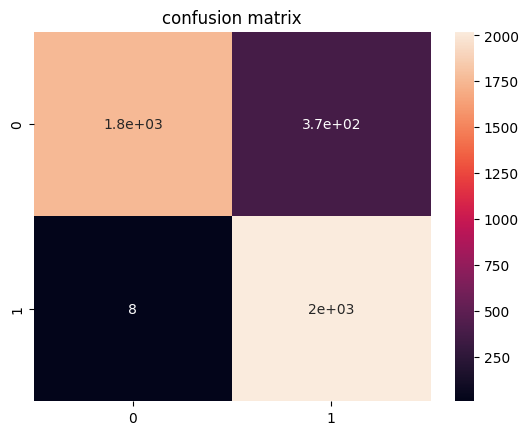

In [74]:
con = confusion_matrix(ytest,y_pred)
sns.heatmap(con,annot=True)
plt.title("confusion matrix")


In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest,y_pred)

0.9084134615384616